# Other boundary Conditions: Neumann and Robin

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mtrl-ubc/mtrl361/blob/main/transient-heat-transfer/other_boundary_conditions.ipynb)

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

In addition to Dirichlet boundary conditions, we can also implement Neumann boundary conditions, which specify the heat flux at the boundaries.
```{figure} combined_dirichlet_robin.png
:label: combined_robin_dirichlet
:alt: Dirichlet and Robin Boundary Conditions
:align: center
Representation of Dirichlet and Robin boundary conditions for 1D transient heat conduction in a rod.
```
The boundary conditions for this case are:
- Left boundary: $\frac{\partial T}{\partial x}(0, t) = 0$ (Dirichlet)
- Right boundary: $\frac{\partial T}{\partial x}(L, t) = -h(T(L, t) - T_{amb})$ (convective heat loss)

```{exercise}
:label: neumann_robin_explicit
Implement the explicit finite difference method to solve the 1D transient heat conduction equation with Neumann boundary conditions. Consider a rod of length $L$ with the following conditions:
|Material Properties | Simulation Parameters | Boundary Conditions |
|--------------------|-----------------------|---------------------|
| Thermal diffusivity, $\alpha: 1.2 \times 10^{-5} m²/s$ | Length of the rod, $L: 0.1 m$ | $T(x, 0) = 400 °C$ |
| Thermal conductivity, $k: 45 W/m·C$ | Time step, $\Delta t: 0.1 s$ | $T(0, t) = 400 °C$ (Dirichlet) |
|                    | Spatial step, $\Delta x: 0.01 m$ | $h = 2000 W/m²K, T_{amb} = 25 °C$ (Robin) |
```

In [2]:
# Material properties and simulation parameters for Neumann BCs
time_final = 40 # s
alpha = 1.2e-5  # m^2/s
k = 45        # W/m·C
L = 0.1         # m
dt = 0.1       # s
dx = 0.01       # m
T_init = 400.0   # °C
T_L = 400.0     # °C
h = 2000.0       # W/m^2/K
T_amb = 25.0     # °C
num_node = int(L/dx) + 1
num_ts = int(time_final/dt)    # total time steps
# Calculate Fourier number
Fo = alpha * dt / dx**2
Bi = h * dx / k
print("Fourier number (Fo):", Fo)
print("Biot number (Bi):", Bi)

Fourier number (Fo): 0.012
Biot number (Bi): 0.4444444444444444


## Explicit Method with Robin and Dirichlet BCs
The explicit method can also be adapted to handle Neumann boundary conditions. The finite difference equations for the interior nodes remain the same, but we need to modify the equations at the boundaries to account for the specified heat fluxes.
The equations for the boundaries become:
- Left boundary ($i=0$): $ T_0^{n+1} = T_1^{n+1} $
- Right boundary ($i=N_x$): $ T_{N_x}^{n+1} = 2Fo \, (T_{N_x-1}^{n} + Bi \, T_{amb}) + (1 - 2Fo(1 + Bi)) \, T_{N_x}^{n} $

In [3]:
# Let us implement the explicit method with Neumann BCs
# Initialize temperature array for explicit method with Neumann BCs
T_neumann = np.zeros((num_node, num_ts)) # T[i, n] - n is the number of time step, i is the node
# Set initial condition
T_neumann[:, 0] = T_init
# Set left boundary condition (insulated)
T_neumann[0, :] = T_L

In [4]:
# Let's use a function to implement the explicit method with Neumann BCs
def explicit_neumann_step(T, Fo, Bi, T_amb, n, num_node):
    T_new = np.zeros(num_node)
    # Update interior nodes
    for i in range(1, num_node - 1):
        T_new[i] = T[i, n] + Fo * (T[i + 1, n] - 2 * T[i, n] + T[i - 1, n])
    # Apply Neumann boundary conditions
    T_new[0] = T[1, n]  # Insulated boundary condition
    T_new[-1] = (2 * Fo * (T[-2, n] + Bi * T_amb) +
                  (1 - 2 * Fo * (1 + Bi)) * T[-1, n])  # Convective boundary condition
    return T_new

In [5]:
# Explicit method solver with Neumann BCs
for n in range(num_ts - 1):
    T_neumann[:, n + 1] = explicit_neumann_step(T_neumann, Fo, Bi, T_amb, n, num_node)

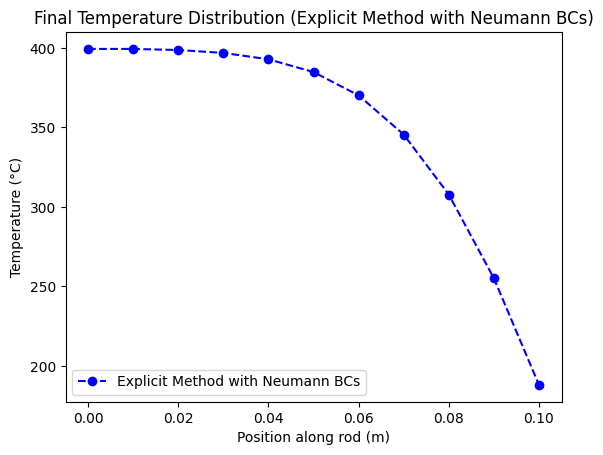

In [6]:
# Plot final temperature distribution for explicit method with Neumann BCs
plt.plot(np.linspace(0, L, num_node), T_neumann[:, -1],
            'bo--', label='Explicit Method with Neumann BCs')
plt.xlabel('Position along rod (m)')
plt.ylabel('Temperature (°C)')
plt.title('Final Temperature Distribution (Explicit Method with Neumann BCs)')
plt.legend()
plt.show()

## Implicit Method with Robin and Neumann BCs
The implicit method can also be adapted to handle Neumann boundary conditions. Similar to the explicit method, the finite difference equations for the interior nodes remain the same, but we need to modify the equations at the boundaries to account for the specified heat fluxes.
```{figure} combined_robin_neumann.png
:label: combined_neumann_robin
:alt: Neumann and Robin Boundary Conditions
:align: center
Representation of Neumann and Robin boundary conditions for 1D transient heat conduction in a rod.
```
In this case, the left boundary is insulated, and the right boundary has convective heat loss.
The equations for the boundaries become:
- Left boundary ($i=0$): $ T_1^{n+1} = -2Fo(T_1^n - T_2^{n}) + T_1^{n} $
- Right boundary ($i=N_x$): $ -2Fo \, T_{N_x-1}^{n+1} + (2Fo(1 + Bi) + 1) \, T_{N_x}^{n+1} = T_{N_x}^{n} + 2Fo \, Bi \, T_{amb} $

In [7]:
# Initialize temperature array for implicit method with Neumann BCs
T_neumann = np.zeros((num_node, num_ts)) # T[i, n] - n is the number of time step, i is the node
# Set initial condition
T_neumann[:, 0] = T_init

In [8]:
# Implicit method solver with Neumann BCs
for n in range(num_ts - 1):
    # Set up the coefficient matrix A and right-hand side vector b
    A = np.zeros((num_node, num_node)) # Coefficient matrix
    b = np.zeros(num_node)              # Right-hand side vector
    # Fill the coefficient matrix A
    for i in range(1, num_node - 1):
        A[i, i - 1] = -Fo
        A[i, i] = 1 + 2 * Fo
        A[i, i + 1] = -Fo
    # Apply Neumann boundary conditions in matrix A
    A[0, 0] = -2 * Fo + 1
    A[0, 1] = 2 * Fo  # Adiabatic boundary condition
    A[-1, -2] = -2 * Fo
    A[-1, -1] = 2 * Fo * (1 + Bi) + 1  # Convective boundary condition
    # Fill the right-hand side vector b
    for i in range(1, num_node - 1):
        b[i] = T_neumann[i, n]
    # Apply Neumann boundary conditions in vector b
    b[0] = T_init
    b[-1] = T_neumann[-1, n] + (2*Fo*Bi * T_amb)  # Convective boundary condition
    # Solve the linear system A * T_new = b
    T_new = np.linalg.solve(A, b)
    # Update the temperature array for the next time step
    T_neumann[:, n + 1] = T_new

```{tip} Using the subplots function
The `subplots` function in Matplotlib allows you to create multiple plots in a single figure. You can specify the number of rows and columns of subplots, and then access each subplot using indexing as `ax[i]` where `i` is the index of subplot. The `set_title`, `set_xlabel`, and `set_ylabel` methods can be used to set titles and labels for each subplot individually.
```

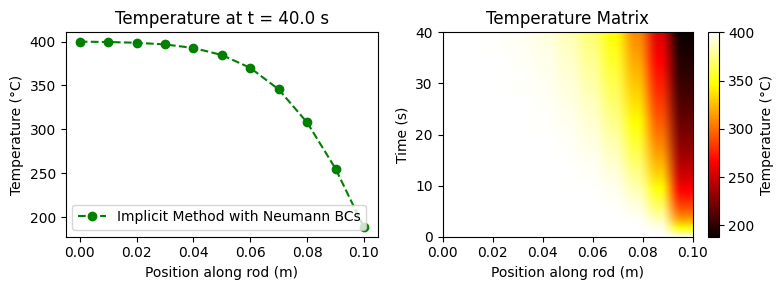

In [9]:
# Plot final temperature distribution for implicit method with Neumann BCs
fig, ax = plt.subplots(1,2, figsize=(8, 3))
ax[0].plot(np.linspace(0, L, num_node), T_neumann[:, -1],
            'go--', label='Implicit Method with Neumann BCs')
ax[0].set_xlabel('Position along rod (m)')
ax[0].set_ylabel('Temperature (°C)')
ax[0].set_title('Temperature at t = {:.1f} s'.format(time_final))
ax[0].legend()

# Visualize the matrix after computation for implicit method with Neumann BCs
im1=ax[1].imshow((T_neumann.T), aspect='auto', cmap='hot', origin='lower', extent=[0, L, 0, dt*num_ts])
fig.colorbar(im1, ax=ax[1], label='Temperature (°C)')
ax[1].set_ylabel('Time (s)')
ax[1].set_xlabel('Position along rod (m)')
ax[1].set_title('Temperature Matrix')
plt.tight_layout()
plt.show()